# XAI: Shap on the best model

In this notebook the shap technique is presented, along with the testing result for the best validation model.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# define basic files
FEATURES_DIR = os.path.join('..', 'data', 'features')
TRAIN_CSV_FILE = os.path.join('..', 'data', 'training_set.csv')
TEST_CSV_FILE = os.path.join('..', 'data', 'testing_set.csv')

# load the train data label
train_file = pd.read_csv(TRAIN_CSV_FILE)
test_file = pd.read_csv(TEST_CSV_FILE)

def load_subset_features( data, subset ):
    """ We load the pre-stored features"""
    features = np.load( os.path.join( FEATURES_DIR, subset_name + '.npy'), allow_pickle=True )[()]
    return [ features[fname] for fname in data['file'] ]

def get_fold_features( train_fold, valid_fold, subset_name):
    """ Load the extracted features, from the pre-stored files """
    features = np.load( os.path.join( FEATURES_DIR, subset_name + '.npy'), allow_pickle=True )[()]
    train_features = [ features[fname] for fname in train_fold['file'] ]
    valid_features = [ features[fname] for fname in valid_fold['file'] ]
    return train_features, valid_features

def get_raw_features( fold_data ):
    """ 
    Stack the features for a full-training on the features.
    We just need to concatenate the features for each sample.
    """
    fts_order = [ 'hu_bin', 'fourier_real', 'fourier_imag', 'stats', 'gabor', 'lbp', 'haralick' ]
    data_fts = [ np.concatenate([ sample[ftname] for ftname in fts_order] ) for sample in fold_data ]
    data_fts = np.stack( data_fts )
    data_fts[ np.isnan(data_fts) ] = 0
    return data_fts

## 1. Best SVM model:

Here we test the best `SVM` model from the grid search.

In [39]:
best_params = {
    'C': 100,
    'gamma': 0.001,
    'kernel': 'rbf',
    'subset': 'small_with_noise_inverted'
}

In [40]:
from sklearn.svm import SVC

# make all the combinations for the experiments
svm_c, svm_gamma, svm_kernel = best_params['C'], best_params['gamma'], best_params['kernel']
data_subset = best_params['subset']
    
tfold_data, ttfold_data = train_file.copy(), test_file.copy()
tfold_Y, ttfold_Y = tfold_data['label'].values, ttfold_data['label'].values
tfold_fts, ttfold_fts = get_fold_features( tfold_data, ttfold_data, subset_name=data_subset )

# raw features
tfold_fts_raw = get_raw_features( tfold_fts )
ttfold_fts_raw = get_raw_features( ttfold_fts )
        
### Raw Testing
clf = make_pipeline(StandardScaler(), SVC(C=svm_c, kernel=svm_kernel, gamma=svm_gamma, class_weight='balanced'))
clf.fit( tfold_fts_raw, tfold_Y )
ttfold_raw_pred = clf.predict( ttfold_fts_raw )

raw_acc = clf.score( ttfold_fts_raw, ttfold_Y )
print("ACC:", raw_acc )

raw_f1 = f1_score( ttfold_Y, ttfold_raw_pred, average=None )
print("F1:", raw_f1 )

raw_f1_macro = f1_score( ttfold_Y, ttfold_raw_pred, average='macro')
print("F1 Macro:", raw_f1_macro )

ACC: 0.8115942028985508
F1: [0.84805654 0.86737089 0.53446191]
F1 Macro: 0.7499631132137349


Shap Analysis:

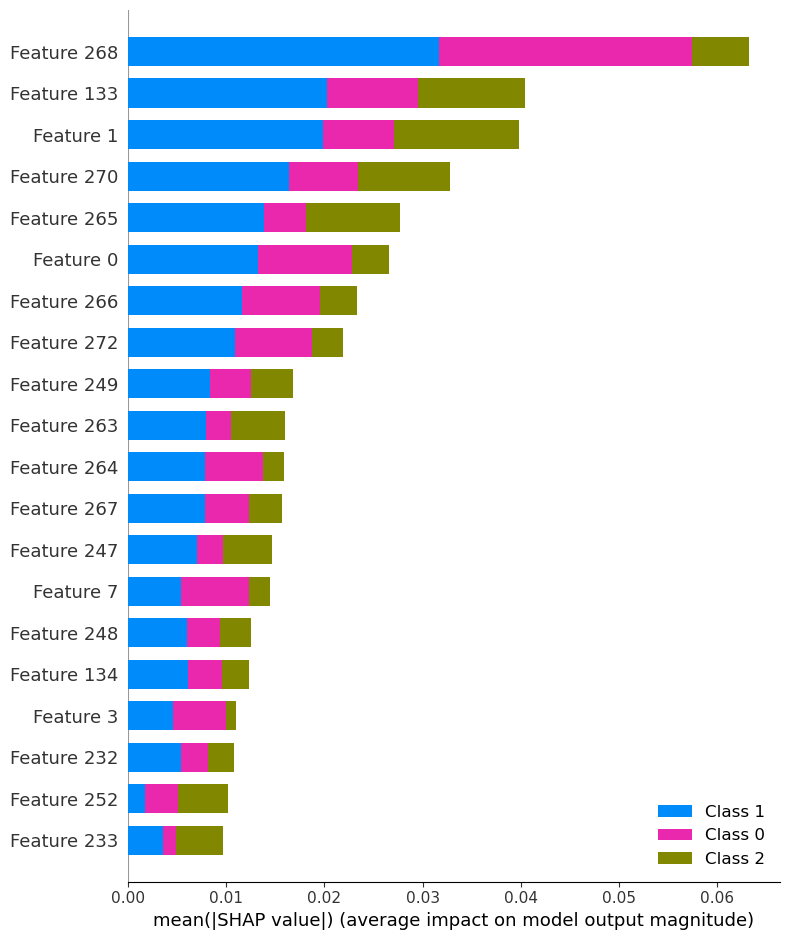

In [31]:
import shap

# Initialize the explainer with the model and the dataset
explainer = shap.Explainer(clf[1])

shap_values = explainer.shap_values(ttfold_fts_raw)
shap.summary_plot( shap_values, ttfold_fts_raw )

In [44]:
features = [ 'hu_bin', 'fourier_real', 'fourier_imag', 'stats', 'gabor', 'lbp', 'haralick' ]

[ tfold_fts[0][ftname].shape[0] for ftname in features ]

[4, 64, 64, 4, 96, 34, 8]

## 2. Random Forest

In [37]:
best_params = {
    'n_estimators': 50, 
    'subset': 'medium_with_noise_not_inverted'
}

from sklearn.ensemble import RandomForestClassifier

# make all the combinations for the experiments
rf_estimators = best_params['n_estimators']
data_subset = best_params['subset']
    
tfold_data, ttfold_data = train_file.copy(), test_file.copy()
tfold_Y, ttfold_Y = tfold_data['label'].values, ttfold_data['label'].values
tfold_fts, ttfold_fts = get_fold_features( tfold_data, ttfold_data, subset_name=data_subset )

# raw features
tfold_fts_raw = get_raw_features( tfold_fts )
ttfold_fts_raw = get_raw_features( ttfold_fts )
        
### Raw Testing
clf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=rf_estimators, class_weight='balanced'))
clf.fit( tfold_fts_raw, tfold_Y )
ttfold_raw_pred = clf.predict( ttfold_fts_raw )

raw_acc = clf.score( ttfold_fts_raw, ttfold_Y )
print("ACC:", raw_acc )

raw_f1 = f1_score( ttfold_Y, ttfold_raw_pred, average=None )
print("F1:", raw_f1 )

raw_f1_macro = f1_score( ttfold_Y, ttfold_raw_pred, average='macro')
print("F1 Macro:", raw_f1_macro )

ACC: 0.8093397745571659
F1: [0.86173481 0.82566429 0.24311927]
F1 Macro: 0.6435061236210661


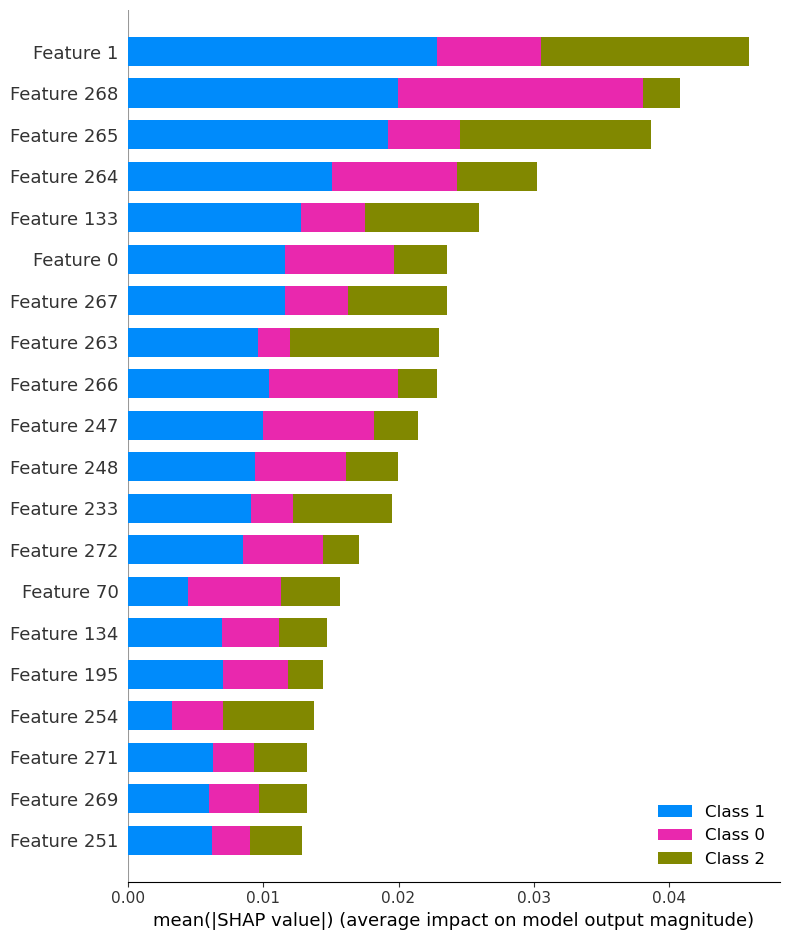

In [38]:
import shap

# Initialize the explainer with the model and the dataset
explainer = shap.Explainer( clf[1] )

shap_values = explainer.shap_values(ttfold_fts_raw)
shap.summary_plot( shap_values, ttfold_fts_raw )